In [2]:
import numpy as np
import pandas as pd
import random
import math
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import heapq
from typing import *
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [3]:
import sys
sys.path.insert(1, "../")
from utils.dual_space import *
from utils.linkedlist import *
from utils.ray_sweep import *

Loading the dataset from Kaggle

In [4]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("currie32/crimes-in-chicago")

print("Path to dataset files:", path)

Path to dataset files: /home/mohsen/.cache/kagglehub/datasets/currie32/crimes-in-chicago/versions/1


In [5]:
data = pd.read_csv(path + "/Chicago_Crimes_2012_to_2017.csv", index_col=0)
data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,...,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,False,...,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,True,...,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


Pre-prcessing the dataset. Converting the columns to categorial.

In [6]:
data.shape

(1456714, 22)

In [7]:
data = data.dropna()
data = data.drop(['ID'], axis=1)
data = data.drop(['Case Number'], axis=1)
data['date2'] = pd.to_datetime(data['Date'])
data['Year'] = data['date2'].dt.year
data['Month'] = data['date2'].dt.month
data['Day'] = data['date2'].dt.day
data['Hour'] = data['date2'].dt.hour
data['Minute'] = data['date2'].dt.minute
data['Second'] = data['date2'].dt.second
data = data.drop(['Date'], axis=1)
data = data.drop(['date2'], axis=1)
data = data.drop(['Updated On'], axis=1)
data.head()

/tmp/ipykernel_3500924/4224618777.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date2'] = pd.to_datetime(data['Date'])


,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,...,Y Coordinate,Year,Latitude,Longitude,Location,Month,Day,Hour,Minute,Second
3,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10.0,24.0,...,1893681.0,2016,41.864073,-87.706819,"(41.864073157, -87.706818608)",5,3,23,40,0
89,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3.0,20.0,...,1864330.0,2016,41.782922,-87.604363,"(41.782921527, -87.60436317)",5,3,21,40,0
197,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,15.0,37.0,...,1904819.0,2016,41.894908,-87.758372,"(41.894908283, -87.758371958)",5,3,23,31,0
673,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,False,1532,15.0,28.0,...,1901475.0,2016,41.885687,-87.749516,"(41.885686845, -87.749515983)",5,3,22,10,0
911,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,15.0,28.0,...,1901675.0,2016,41.886297,-87.761751,"(41.886297242, -87.761750709)",5,3,22,0,0


In [8]:
data['Block'] = pd.factorize(data["Block"])[0]
data['IUCR'] = pd.factorize(data["IUCR"])[0]
data['Description'] = pd.factorize(data["Description"])[0]
data['Location Description'] = pd.factorize(data["Location Description"])[0]
data['FBI Code'] = pd.factorize(data["FBI Code"])[0]
data['Location'] = pd.factorize(data["Location"])[0]
data["Primary Type"] = pd.factorize(data["Primary Type"])[0]

Removing the outliars and normalizing

In [9]:
data = data[data["Latitude"] > 40]
long, lat = data["Longitude"], data["Latitude"]
data["Longitude"] = (long - long.min()) / (long.max() - long.min())
data["Latitude"] = (lat - lat.min()) / (lat.max() - lat.min())

Visualizing the points

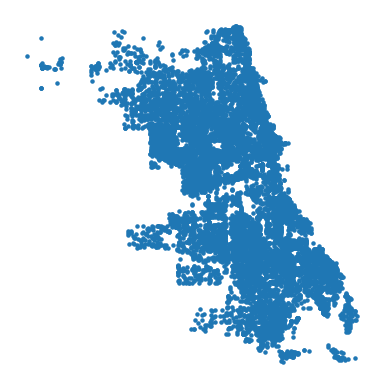

In [11]:
from shapely.geometry import Point
from geopandas import GeoDataFrame
from shapely.geometry import Point

sample_data = data.sample(frac=0.01, random_state=1)

chicri_geometry = [Point(xy) for xy in zip(sample_data["Longitude"], sample_data["Latitude"])]
chicri_points = GeoDataFrame(sample_data, geometry=chicri_geometry)

chicri_points_map = chicri_points.plot(markersize=5)
chicri_points_map.set_axis_off()

In this section, we train a classification model and evaluate the accuracy. This is the black-box model mentioned in the paper.

In [12]:
final_df = data.sample(n=500, random_state=1)
features = ["Month", "Hour", "Latitude", "Longitude", "Primary Type", "IUCR", "FBI Code"]
X_train = final_df[features]
y_train = final_df["Arrest"]
final_df["Lat"] = final_df["Latitude"]
final_df["Lon"] = final_df["Longitude"]
final_df["Target"] = final_df["Arrest"]
data["Lat"] = data["Latitude"]
data["Lon"] = data["Longitude"]
data["Target"] = data["Arrest"]

Rotate the points to cover all possible directions.

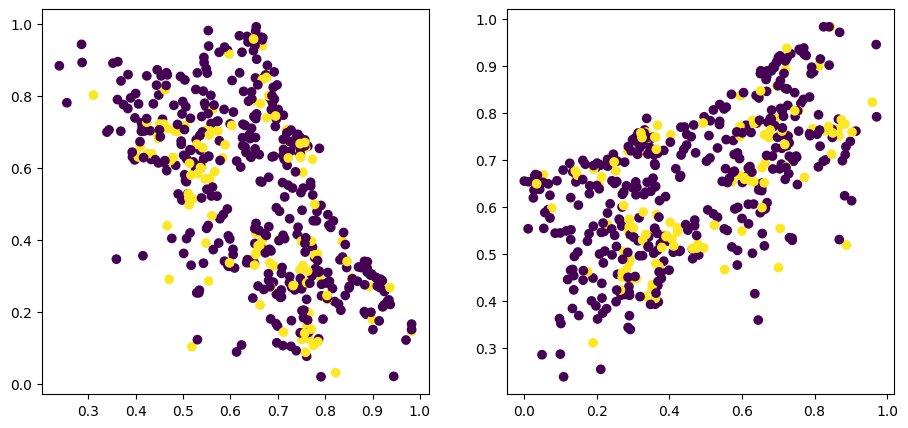

In [13]:
x_train_new = np.array(final_df[["Lon", "Lat"]])
y_train_new = np.array(final_df["Target"])

max_y = np.max(x_train_new[:, 1])
x_train_new_prime = np.array(list(map(lambda row: [max_y - row[1] , row[0]], x_train_new)))

fig, axis = plt.subplots(1, 2, figsize=(11, 5))
axis[0].scatter(x=x_train_new[:, 0], y=x_train_new[:, 1], c=final_df["Target"])
axis[1].scatter(x=x_train_new_prime[:, 0], y=x_train_new_prime[:, 1], c=final_df["Target"])

In [14]:
x_train_new.shape, y_train_new.shape, final_df.shape, data.shape

((500, 2), (500,), (500, 26), (1418291, 26))

In [15]:
target = "Arrest"

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from joblib import dump, load

clf = MLPClassifier(random_state=1)

# Load
clf = load('../models/Model_MLP_1.0_v0.1.joblib')

# Train
# clf.fit(data[features], data[target])


y_pred_train = clf.predict(data[features])
print(f"Accuracy on train: {accuracy_score(data[target], y_pred_train)}")
print(f"F1: {f1_score(data[target], y_pred_train)}")

/home/mohsen/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mohsen/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy on train: 0.8742493606742199
F1: 0.7249414337511239


### Ray Sweeping Algorithm

In [18]:
import time


start = time.time()
points = pd.DataFrame(x_train_new)
points_prime = pd.DataFrame(x_train_new_prime)

skew_heap = []
max_skew_1 = MaxSkewCalculator(points, skew_heap, lambda x: tuple([x[0], x[1]]), math.pi / 10)
max_skew_2 = MaxSkewCalculator(points_prime, skew_heap, lambda x: tuple([-x[1], x[0]]), math.pi / 10)

max_skew_1.preprocess()
max_skew_2.preprocess()

max_skew_1.train()
max_skew_2.train()

end = time.time()
print(f"time: {end - start}")

Number of intersects: 123627
Number of intersects: 123703
Reached Y axis, finish.
Reached Y axis, finish.
time: 8.003540754318237


/home/mohsen/unknown/git_rep/Mining_U3Ms/2D/../utils/ray_sweep.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  candidate_points, key=lambda x: np.arctan(x[1] / x[0])


List the high skewed directions

In [19]:
list(max_skew_2.get_high_skews(top_k=10))

[(-0.2057857645622841, (-0.253825600170482, 0.7461743998295179)),
 (-0.16193084252878123, (-0.4278736688994582, 0.5721263311005417)),
 (-0.14185970857286812, (0.22581697514030413, 0.7741830248596959)),
 (-0.09411194677570671, (0.40874448088232596, 0.5912555191176739)),
 (-0.07986596218205758, (0.57255443033453, 0.42744556966547)),
 (-0.03192991856204419, (-0.5910234054677024, 0.4089765945322976)),
 (-0.007646595996045943, (-0.777762657083927, 0.2222373429160731)),
 (-0.0071073220013677845, (0.7479935094392295, 0.2520064905607705))]

Visualize the high skewed directions

(0.0, 0.9709225377656687)

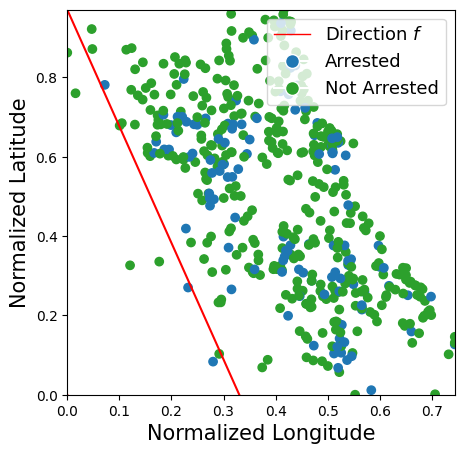

In [20]:
from matplotlib.lines import Line2D

# Enter manually here, based on the previous output!
f_direction = (-0.253825600170482, 0.7461743998295179)

fig, ax = plt.subplots(figsize=(5,5))
points_np = np.array(points)
xmin, xmax = np.min(points_np[:, 0]), np.max(points_np[:, 0])
ymin, ymax = np.min(points_np[:, 1]), np.max(points_np[:, 1])
label = y_train_new
ax.scatter(x=points_np.T[0], y=points_np.T[1], c=["#1f77b4" if x==1 else "#2ca02c" for x in label])
x = np.arange(xmin, 2 * xmax)
f = f_direction
f = f / linalg.norm(f)
y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
ax.plot(x, y, color="red")
ax.plot(x, y + max(ymax, xmax), color="red")
plt.xlabel("Normalized Longitude", fontsize=15)
plt.ylabel("Normalized Latitude", fontsize=15)

line = Line2D([0], [0], label='Direction $f$', color='red', linewidth=1)
b = Line2D([0], [0], marker='o', color='w', label='Arrested', markerfacecolor='#1f77b4', markersize=10)
b2 = Line2D([0], [0], marker='o', color='w', label='Not Arrested', markerfacecolor='#2ca02c', markersize=10)
ax.legend(handles=[line, b, b2], fontsize=13, loc="upper right")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

In [21]:
f = np.array(f)
p_f = np.dot(points, f)
mean = np.mean(p_f)
sd = np.std(p_f)
median = np.median(p_f)
sk = (mean - median) / sd

print("Skew value is ", sk)

Skew value is  -0.20578706871512661


Visualize the tail of skew for a specific percentile.

In [ ]:
# Percentil (10%)
q = 0.01

df = data.copy(deep=True)
df = df[["Lon", "Lat"]]
df["Lat"] = data["Lat"] - data["Lat"].min()
df["Lon"] = data["Lon"] - data["Lon"].min()

q1 = np.quantile(np.dot(df[["Lon", "Lat"]], f), q if -sk < 0 else (1 - q))
tail = data[df.apply(lambda x: np.dot((x[0], x[1]), f) < q1 if -sk < 0 else np.dot((x[0], x[1]), f) > q1, axis=1)]
print(tail.shape, df.shape)

tail = tail.sample(frac=0.1)

fig, ax = plt.subplots(figsize=(5,5))
points_np = np.array(tail[["Lon", "Lat"]])
label = tail["Target"]
ax.scatter(x=points_np.T[0], y=points_np.T[1], c=["#1f77b4" if x==1 else "#2ca02c" for x in label])
x = np.arange(xmin, 2 * xmax)
f = f / linalg.norm(f)
y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
ax.plot(x, y, color="red")
ax.plot(x, y + max(ymax, xmax), color="red")

line = Line2D([0], [0], label='Direction $f$', color='red', linewidth=1)
b = Line2D([0], [0], marker='o', color='w', label='Arrested', markerfacecolor='#1f77b4', markersize=10)
b2 = Line2D([0], [0], marker='o', color='w', label='Not Arrested', markerfacecolor='#2ca02c', markersize=10)
ax.legend(handles=[line, b, b2], fontsize=13, loc="upper right")

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel("Normalized Longitude", fontsize=15)
plt.ylabel("Normalized Latitude", fontsize=15)

Evaluate model on the tail.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

data_sample_train = tail[features]
data_sample_target = tail["Target"]

y_pred_train = clf.predict(np.array(data_sample_train))
print(f"Accuracy on train: {accuracy_score(data_sample_target, y_pred_train)}")
print(f"F1: {f1_score(data_sample_target, y_pred_train)}")